# Quickstart

Check out the quickstart tutorial: https://trak.readthedocs.io/en/latest/quickstart.html.

Use this notebook to follow along (it contains only the code from the quickstart tutorial, no comments/explanations).

We ran this notebook on a 1xA100 80G GPU. Depending on your setup, you might need to reduce the batch sizes for training & computing TRAK.

If you just want to play around with (pre-computed) TRAK scores, check out this Colab notebook instead: https://colab.research.google.com/drive/1Mlpzno97qpI3UC1jpOATXEHPD-lzn9Wg?usp=sharing.

## Train and save model checkpoints

In [1]:
import os
from pathlib import Path
import wget
from tqdm.auto import tqdm
import numpy as np
import torch
from torch.cuda.amp import GradScaler, autocast
from torch.nn import CrossEntropyLoss, Conv2d, BatchNorm2d
from torch.optim import SGD, lr_scheduler
import torchvision
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Resnet9
class Mul(torch.nn.Module):
    def __init__(self, weight):
        super(Mul, self).__init__()
        self.weight = weight
    def forward(self, x): return x * self.weight


class Flatten(torch.nn.Module):
    def forward(self, x): return x.view(x.size(0), -1)


class Residual(torch.nn.Module):
    def __init__(self, module):
        super(Residual, self).__init__()
        self.module = module
    def forward(self, x): return x + self.module(x)


def construct_rn9(num_classes=10):
    def conv_bn(channels_in, channels_out, kernel_size=3, stride=1, padding=1, groups=1):
        return torch.nn.Sequential(
                torch.nn.Conv2d(channels_in, channels_out, kernel_size=kernel_size,
                            stride=stride, padding=padding, groups=groups, bias=False),
                torch.nn.BatchNorm2d(channels_out),
                torch.nn.ReLU(inplace=True)
        )
    model = torch.nn.Sequential(
        conv_bn(3, 64, kernel_size=3, stride=1, padding=1),
        conv_bn(64, 128, kernel_size=5, stride=2, padding=2),
        Residual(torch.nn.Sequential(conv_bn(128, 128), conv_bn(128, 128))),
        conv_bn(128, 256, kernel_size=3, stride=1, padding=1),
        torch.nn.MaxPool2d(2),
        Residual(torch.nn.Sequential(conv_bn(256, 256), conv_bn(256, 256))),
        conv_bn(256, 128, kernel_size=3, stride=1, padding=0),
        torch.nn.AdaptiveMaxPool2d((1, 1)),
        Flatten(),
        torch.nn.Linear(128, num_classes, bias=False),
        Mul(0.2)
    )
    return model

In [3]:
def get_dataloader(batch_size=256, num_workers=8, split='train', shuffle=False, augment=True):
    if augment:
        transforms = torchvision.transforms.Compose(
                        [torchvision.transforms.RandomHorizontalFlip(),
                         torchvision.transforms.RandomAffine(0),
                         torchvision.transforms.ToTensor(),
                         torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465),
                                                          (0.2023, 0.1994, 0.201))])
    else:
        transforms = torchvision.transforms.Compose([
                         torchvision.transforms.ToTensor(),
                         torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465),
                                                          (0.2023, 0.1994, 0.201))])
        
    is_train = (split == 'train')
    dataset = torchvision.datasets.CIFAR10(root='/tmp/cifar/',
                                           download=True,
                                           train=is_train,
                                           transform=transforms)

    loader = torch.utils.data.DataLoader(dataset=dataset,
                                         shuffle=shuffle,
                                         batch_size=batch_size,
                                         num_workers=num_workers)
    
    return loader

In [4]:
def train(model, loader, lr=0.4, epochs=24, momentum=0.9,
          weight_decay=5e-4, lr_peak_epoch=5, label_smoothing=0.0, model_id=0):
    
    opt = SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    iters_per_epoch = len(loader)
    # Cyclic LR with single triangle
    lr_schedule = np.interp(np.arange((epochs+1) * iters_per_epoch),
                            [0, lr_peak_epoch * iters_per_epoch, epochs * iters_per_epoch],
                            [0, 1, 0])
    scheduler = lr_scheduler.LambdaLR(opt, lr_schedule.__getitem__)
    scaler = GradScaler()
    loss_fn = CrossEntropyLoss(label_smoothing=label_smoothing)

    for ep in range(epochs):
        for it, (ims, labs) in enumerate(loader):
            ims = ims.cuda()
            labs = labs.cuda()
            opt.zero_grad(set_to_none=True)
            with autocast():
                out = model(ims)
                loss = loss_fn(out, labs)

            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()
            scheduler.step()
        if ep in [12, 15, 18, 21, 23]:
            torch.save(model.state_dict(), f'./checkpoints/sd_{model_id}_epoch_{ep}.pt')
        
    return model

In [5]:
os.makedirs('./checkpoints', exist_ok=True)
loader_for_training = get_dataloader(batch_size=512, split='train', shuffle=True)

# you can modify the for loop below to train more models
for i in tqdm(range(1), desc='Training models..'):
    model = construct_rn9().to(memory_format=torch.channels_last).cuda()
    model = train(model, loader_for_training, model_id=i)

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 170498071/170498071 [00:01<00:00, 86304595.48it/s]


Extracting /tmp/cifar/cifar-10-python.tar.gz to /tmp/cifar/


Training models..:   0%|          | 0/1 [00:00<?, ?it/s]

### Make a list of checkpoints

In [6]:
ckpt_files = sorted(list(Path('./checkpoints').rglob('*.pt')))
ckpts = [torch.load(ckpt, map_location='cpu') for ckpt in ckpt_files]

### Check test accuracy

In [7]:
model = construct_rn9().to(memory_format=torch.channels_last).cuda()
model.load_state_dict(ckpts[-1])
model = model.eval()

In [8]:
loader = get_dataloader(split='val', augment=False)
model.eval()

with torch.no_grad():
    total_correct, total_num = 0., 0.
    for ims, labs in tqdm(loader):
        ims = ims.cuda()
        labs = labs.cuda()
        with autocast():
            out = model(ims)
            total_correct += out.argmax(1).eq(labs).sum().cpu().item()
            total_num += ims.shape[0]

    print(f'Accuracy: {total_correct / total_num * 100:.1f}%')

Files already downloaded and verified


  0%|          | 0/40 [00:00<?, ?it/s]

Accuracy: 91.6%


## Set up the TRAKer class

In [9]:
batch_size = 128
loader_train = get_dataloader(batch_size=batch_size, split='train')

Files already downloaded and verified


In [10]:
from trak import TRAKer

traker = TRAKer(model=model,
                task='image_classification',
                proj_dim=4096,
                train_set_size=len(loader_train.dataset))

                            Report any issues at https://github.com/MadryLab/trak/issues
INFO:STORE:No existing model IDs in /mnt/xfs/home/krisgrg/projects/trak/examples/trak_results.
INFO:STORE:No existing TRAK scores in /mnt/xfs/home/krisgrg/projects/trak/examples/trak_results.


## Compute TRAK features for train data

In [12]:
for model_id, ckpt in enumerate(tqdm(ckpts)):
    traker.load_checkpoint(ckpt, model_id=model_id)
    for batch in tqdm(loader_train):
        batch = [x.cuda() for x in batch]
        traker.featurize(batch=batch, num_samples=batch[0].shape[0])

traker.finalize_features()

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Finalizing features for all model IDs..: 100%|████████████████████████████████████████████████████████████████████████████| 5/5 [01:08<00:00, 13.77s/it]


## Compute TRAK scores for targets

In [13]:
loader_targets = get_dataloader(batch_size=batch_size, split='val', augment=False)

Files already downloaded and verified


In [14]:
for model_id, ckpt in enumerate(tqdm(ckpts)):
    traker.start_scoring_checkpoint(exp_name='quickstart',
                                    checkpoint=ckpt,
                                    model_id=model_id,
                                    num_targets=len(loader_targets.dataset))
    for batch in loader_targets:
        batch = [x.cuda() for x in batch]
        traker.score(batch=batch, num_samples=batch[0].shape[0])

scores = traker.finalize_scores(exp_name='quickstart').cpu().numpy()

  0%|          | 0/5 [00:00<?, ?it/s]

Finalizing scores for all model IDs..: 100%|██████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.42it/s]
INFO:STORE:Saving scores in /mnt/xfs/home/krisgrg/projects/trak/examples/trak_results/scores/scores_quickstart.npy


In [ ]:
scores = np.load('<path from cell above>')

## Visualize TRAK scores

In [15]:
from matplotlib import pyplot as plt

In [16]:
ds_train = torchvision.datasets.CIFAR10(root='/tmp/cifar/', download=True, train=True)
ds_val = torchvision.datasets.CIFAR10(root='/tmp/cifar/', download=True, train=False)

Files already downloaded and verified
Files already downloaded and verified


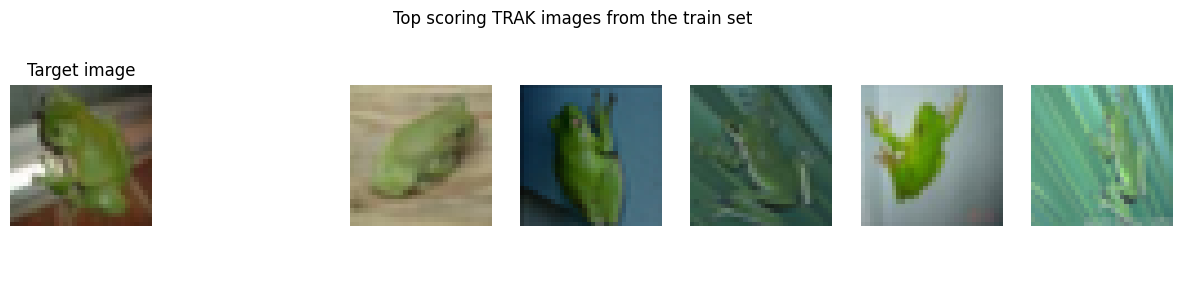

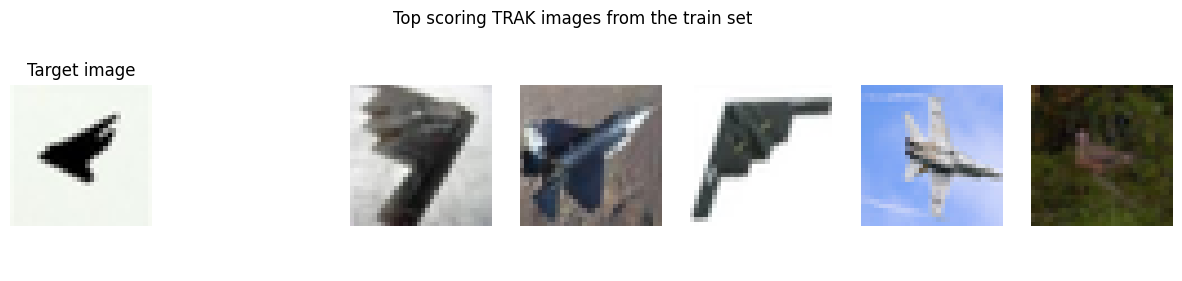

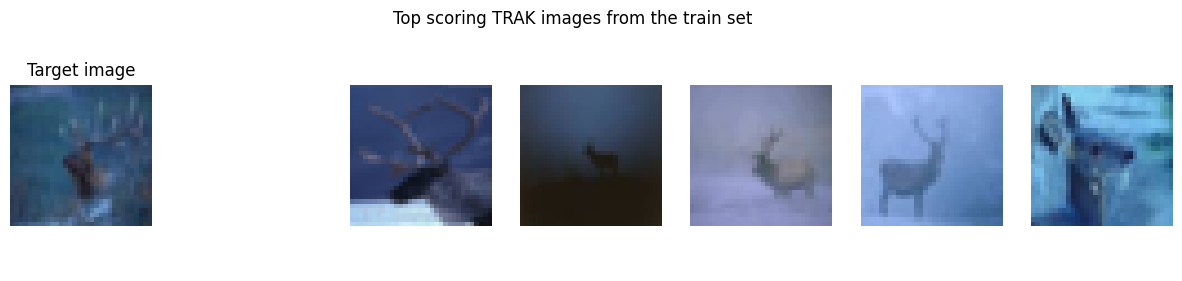

In [17]:
for i in [7, 21, 22]:

    fig, axs = plt.subplots(ncols=7, figsize=(15, 3))
    fig.suptitle('Top scoring TRAK images from the train set')
    
    axs[0].imshow(ds_val[i][0])
    
    axs[0].axis('off'); axs[0].set_title('Target image')
    axs[1].axis('off')
    
    top_trak_scorers = scores[:, i].argsort()[-5:][::-1]
    for ii, train_im_ind in enumerate(top_trak_scorers):
        axs[ii + 2].imshow(ds_train[train_im_ind][0]); axs[ii + 2].axis('off')

    fig.show()

You can also explore TRAK scores computed for CIFAR-10 from multiple independently-trained models (10, 100, 1000 models) in this [colab notebook](https://colab.research.google.com/drive/1Mlpzno97qpI3UC1jpOATXEHPD-lzn9Wg?usp=sharing).

## Bonus: evaluate counterfactuals

We exactly follow the steps in https://docs.ffcv.io/ffcv_examples/cifar10.html. Additionally, we train on *subsets* of CIFAR-10, parametrized by the `masks` arrays below. We collect the model outputs for each retraining on a different subset (mask) in a separate array `margins`.

We train a total of 10,000 models. Note that this is not necessary to get TRAK scores. This step is only necessary to get (very high quality) LDS correlation estimates.

In [18]:
from scipy.stats import spearmanr

In [19]:
def eval_correlations(scores, tmp_path):    
    masks_url = 'https://www.dropbox.com/s/x76uyen8ffkjfke/mask.npy?dl=1'
    margins_url = 'https://www.dropbox.com/s/q1dxoxw78ct7c27/val_margins.npy?dl=1'

    masks_path = Path(tmp_path).joinpath('mask.npy')
    wget.download(masks_url, out=str(masks_path), bar=None)
    # num masks, num train samples
    masks = torch.as_tensor(np.load(masks_path, mmap_mode='r')).float()
    
    margins_path = Path(tmp_path).joinpath('val_margins.npy')
    wget.download(margins_url, out=str(margins_path), bar=None)
    # num , num val samples
    margins = torch.as_tensor(np.load(margins_path, mmap_mode='r'))

    val_inds = np.arange(10_000)
    preds = masks @ scores
    rs = []
    ps = []
    for ind, j in tqdm(enumerate(val_inds)):
        r, p = spearmanr(preds[:, ind], margins[:, j])
        rs.append(r)
        ps.append(p)
    rs, ps = np.array(rs), np.array(ps)
    print(f'Correlation: {rs.mean():.3f} (avg p value {ps.mean():.6f})')
    return rs.mean()

In [20]:
corr = eval_correlations(scores, '.')

0it [00:00, ?it/s]

Correlation: 0.108 (avg p value 0.000654)
